In [14]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [15]:
data = pd.read_csv('./data/GlobalLandTemperaturesByCity.csv')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [17]:
data.dropna(inplace=True)
data['AverageTemperature'] = data['AverageTemperature'].ffill() # fill missing values with the previous value

In [18]:
# convert the longitude and latitude to float values
def parse_latitude(lat):
    if 'N' in lat:
        return float(lat[:-1])
    else:
        return -float(lat[:-1])

def parse_longitude(lon):
    if 'E' in lon:
        return float(lon[:-1])
    else:
        return -float(lon[:-1])

data['Latitude'] = data['Latitude'].apply(parse_latitude)
data['Longitude'] = data['Longitude'].apply(parse_longitude)

In [19]:
# Convert Date
data['dt'] = pd.to_datetime(data['dt'])
data['Year'] = data['dt'].dt.year
data['Month'] = data['dt'].dt.month

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['City_encoded'] = le.fit_transform(data['City'])
data['Country_encoded'] = le.fit_transform(data['Country'])

In [21]:
features = pd.concat([data['Latitude'], data['Longitude'], data['Year'], data['Month'], data['City_encoded'], data['Country_encoded']], axis=1)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = scaler.fit_transform(features)

In [27]:
from sklearn.model_selection import train_test_split

X = features
y = data['AverageTemperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# we are going to use xgboost
# xgboost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework.
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="gpu_hist",  n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8 )
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

c:\Users\kevin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=6, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [32]:
best_model = grid_search.best_estimator_

In [33]:
pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f'RMSE: {rmse}')

c:\Users\kevin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster b

RMSE: 1.4334426022498188


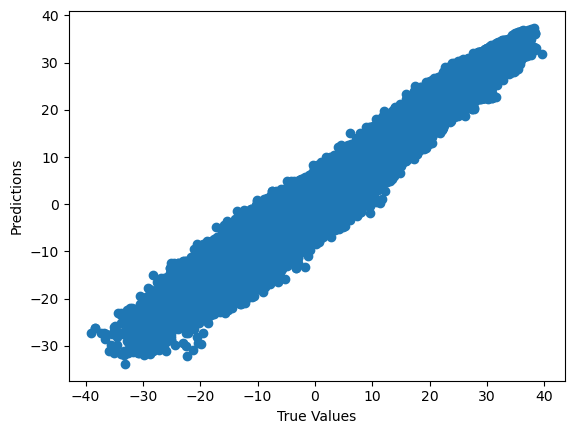

In [34]:
plt.scatter(y_test, pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [35]:
best_model.score(X_test, y_test) # R^2 score: 0.98!!!

0.980841463844225